## Load packages and data

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, SpatialDropout1D, Dropout, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import seaborn as sns

In [2]:
df = pd.read_csv("babbel.csv")

In [3]:
df

,content,score
0,"it's honestly great, the only thing left is to...",5
1,Way too hard to follow. Duolingo is way better.,1
2,Actually useful for learning but I want to lea...,3
3,The audio tests are absolutely terrible lol. L...,1
4,Good app so far. I like that you learn predomi...,4
...,...,...
46621,Only based on vocab? Not useful from a pedagog...,1
46622,Great,5
46623,"Maybe I can't call it a bug, but a misconcepti...",1
46624,App language: English System language: English...,1


#### Class frequencies

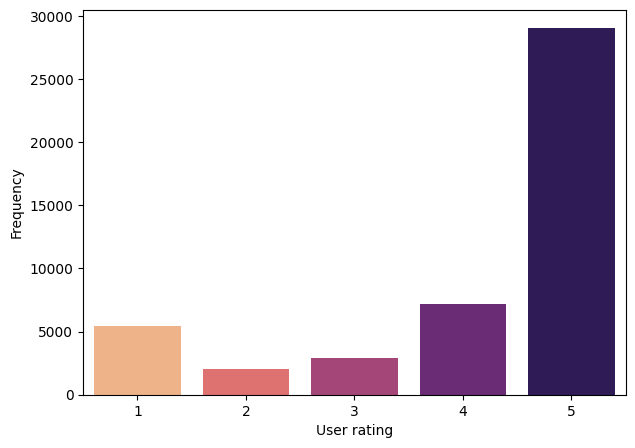

In [71]:
ax = sns.countplot(x = df["score"], palette = "magma_r")
ax.set(xlabel = "User rating", ylabel = "Frequency")
plt.show()

In [74]:
df["score"].value_counts()

5    29024
4     7165
1     5456
3     2924
2     2057
Name: score, dtype: int64

## Preprocess data

#### Remove stop words and lemmatize

In [4]:
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    return [token.lemma_ for token in nlp(text) if token.lemma_.isalpha() and not token.is_stop]

#### Split into train and test subsets

In [5]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df.content, df.score, test_size = 0.2, random_state = 1)

#### Random oversampling

In [6]:
ros = RandomOverSampler(random_state = 1)
X_train_ros, y_train_ros = ros.fit_resample(np.array(X_train).reshape(-1,1), y_train)
#X_train_Tfidf_ros, y_train_ros = ros.fit_resample(X_train_Tfidf, y_train)

#### Random undersampling

In [7]:
rus = RandomUnderSampler(random_state = 1)
X_train_rus, y_train_rus = rus.fit_resample(np.array(X_train).reshape(-1,1), y_train)
#X_train_Tfidf_rus, y_train_rus = rus.fit_resample(X_train_Tfidf, y_train)

#### Preprocessing for machine learning models

In [8]:
vectorizer_Tfidf = TfidfVectorizer(tokenizer = preprocess)
X_train_Tfidf = vectorizer_Tfidf.fit_transform(X_train)
X_test_Tfidf = vectorizer_Tfidf.transform(X_test)

In [9]:
X_train_Tfidf_ros, y_train_ros = ros.fit_resample(X_train_Tfidf, y_train)
X_train_Tfidf_rus, y_train_rus = rus.fit_resample(X_train_Tfidf, y_train)

#### Preprocessing for deep learning models

In [10]:
vocab_size = len(sum([preprocess(x) for x in X_train], [])) + 1
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)

sequence_length = 200

train_sequences = tokenizer.texts_to_sequences([preprocess(x) for x in X_train])
train_padded = pad_sequences(train_sequences, maxlen = sequence_length, padding = "post", truncating = "post")

test_sequences = tokenizer.texts_to_sequences([preprocess(x) for x in X_test])
test_padded = pad_sequences(test_sequences, maxlen = sequence_length, padding = "post", truncating = "post")

train_cat = to_categorical(y_train)
test_cat = to_categorical(y_test)

In [11]:
# Random oversampling
train_sequences_ros = tokenizer.texts_to_sequences([preprocess(x) for x in X_train_ros.flatten()])
train_padded_ros = pad_sequences(train_sequences_ros, maxlen = sequence_length, padding = "post", truncating = "post")

train_cat_ros = to_categorical(y_train_ros)

In [12]:
# Random undersampling
train_sequences_rus = tokenizer.texts_to_sequences([preprocess(x) for x in X_train_rus.flatten()])
train_padded_rus = pad_sequences(train_sequences_rus, maxlen = sequence_length, padding = "post", truncating = "post")

train_cat_rus = to_categorical(y_train_rus)

## Models

#### Logistic regression

In [13]:
clf_logreg = LogisticRegression(max_iter = 1000).fit(X_train_Tfidf, y_train)
y_pred_train_logreg = clf_logreg.predict(X_train_Tfidf)
y_pred_logreg = clf_logreg.predict(X_test_Tfidf)

print("Train:")
print(confusion_matrix(y_train, y_pred_train_logreg))
print(classification_report(y_train, y_pred_train_logreg))

print("Test:")
print(confusion_matrix(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

Train:
[[ 3466    35   107    94   627]
 [  756   213   127   135   436]
 [  562    41   495   299   968]
 [  289    25   113  1095  4159]
 [  246    17    82   284 22629]]
              precision    recall  f1-score   support

           1       0.65      0.80      0.72      4329
           2       0.64      0.13      0.21      1667
           3       0.54      0.21      0.30      2365
           4       0.57      0.19      0.29      5681
           5       0.79      0.97      0.87     23258

    accuracy                           0.75     37300
   macro avg       0.64      0.46      0.48     37300
weighted avg       0.72      0.75      0.70     37300

Test:
[[ 820   16   40   39  212]
 [ 202   12   50   33   93]
 [ 165   16   58   91  229]
 [  75    4   58  180 1167]
 [  88   10   25  107 5536]]
              precision    recall  f1-score   support

           1       0.61      0.73      0.66      1127
           2       0.21      0.03      0.05       390
           3       0.25     

#### Random forest

In [14]:
clf_rf = RandomForestClassifier(random_state = 1).fit(X_train_Tfidf, y_train)
y_pred_train_rf = clf_rf.predict(X_train_Tfidf)
y_pred_rf = clf_rf.predict(X_test_Tfidf)

print("Train:")
print(confusion_matrix(y_train, y_pred_train_rf))
print(classification_report(y_train, y_pred_train_rf))

print("Test:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Train:
[[ 4253    12     7     3    54]
 [   45  1584     8     7    23]
 [   41     6  2174    12   132]
 [   20     0     4  4570  1087]
 [   32     2     9    59 23156]]
              precision    recall  f1-score   support

           1       0.97      0.98      0.98      4329
           2       0.99      0.95      0.97      1667
           3       0.99      0.92      0.95      2365
           4       0.98      0.80      0.88      5681
           5       0.95      1.00      0.97     23258

    accuracy                           0.96     37300
   macro avg       0.97      0.93      0.95     37300
weighted avg       0.96      0.96      0.96     37300

Test:
[[ 806   15   35   16  255]
 [ 207    3   16   29  135]
 [ 180   13   35   51  280]
 [  97    1   23  110 1253]
 [  93    6   19  114 5534]]
              precision    recall  f1-score   support

           1       0.58      0.72      0.64      1127
           2       0.08      0.01      0.01       390
           3       0.27     

#### Bidirectional LSTM

In [15]:
model = Sequential()

embedding_dim = 16
lstm_out = 32

model.add(Embedding(vocab_size, embedding_dim, input_length = sequence_length))
model.add(Bidirectional(LSTM(lstm_out)))
model.add(Dense(6, activation = "softmax"))

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1)
mc = ModelCheckpoint("best_bilstm.h5", monitor = "val_accuracy", mode = "max", verbose = 1, save_best_only = True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 16)           4575584   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 4,588,518
Trainable params: 4,588,518
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(train_padded, train_cat, epochs = 10, validation_data = (test_padded, test_cat), callbacks = [es, mc])

Epoch 1/10
1166/1166 [==============================] - ETA: 0s - loss: 0.8924 - accuracy: 0.6874
Epoch 1: val_accuracy improved from -inf to 0.71092, saving model to best_bilstm.h5
1166/1166 [==============================] - 207s 174ms/step - loss: 0.8924 - accuracy: 0.6874 - val_loss: 0.8036 - val_accuracy: 0.7109
Epoch 2/10
1166/1166 [==============================] - ETA: 0s - loss: 0.7612 - accuracy: 0.7245
Epoch 2: val_accuracy improved from 0.71092 to 0.71553, saving model to best_bilstm.h5
1166/1166 [==============================] - 222s 190ms/step - loss: 0.7612 - accuracy: 0.7245 - val_loss: 0.7919 - val_accuracy: 0.7155
Epoch 2: early stopping


In [19]:
# Load saved model
best_bilstm_model = load_model("best_bilstm.h5")

y_pred_train_bilstm = best_bilstm_model.predict(train_padded)
y_pred_bilstm = best_bilstm_model.predict(test_padded)

print("Training data:")
print(confusion_matrix(y_train, np.argmax(y_pred_train_bilstm, axis = 1)))
print(classification_report(y_train, np.argmax(y_pred_train_bilstm, axis = 1)))

print("Test data:")
print(confusion_matrix(y_test, np.argmax(y_pred_bilstm, axis = 1)))
print(classification_report(y_test, np.argmax(y_pred_bilstm, axis = 1)))

292/292 [==============================] - 7s 22ms/step
Training data:
[[ 3378     1   312   132   506]
 [  866     2   350   180   269]
 [  546     0   555   558   706]
 [  220     0   252  1121  4088]
 [  229     0   119   410 22500]]
              precision    recall  f1-score   support

           1       0.64      0.78      0.71      4329
           2       0.67      0.00      0.00      1667
           3       0.35      0.23      0.28      2365
           4       0.47      0.20      0.28      5681
           5       0.80      0.97      0.88     23258

    accuracy                           0.74     37300
   macro avg       0.59      0.44      0.43     37300
weighted avg       0.70      0.74      0.69     37300

Test data:
[[ 820    1   94   31  181]
 [ 181    0   77   54   78]
 [ 147    0  111   96  205]
 [  62    0   74  219 1129]
 [  73    0   42  128 5523]]
              precision    recall  f1-score   support

           1       0.64      0.73      0.68      1127
           2 

#### Multinomial logistic regression with random oversampling

In [20]:
clf_logreg_ros = LogisticRegression(max_iter = 1000).fit(X_train_Tfidf_ros, y_train_ros)
y_pred_train_logreg_ros = clf_logreg_ros.predict(X_train_Tfidf_ros)
y_pred_logreg_ros = clf_logreg_ros.predict(X_test_Tfidf)

print("Train:")
print(confusion_matrix(y_train_ros, y_pred_train_logreg_ros))
print(classification_report(y_train_ros, y_pred_train_logreg_ros))

print("Test:")
print(confusion_matrix(y_test, y_pred_logreg_ros))
print(classification_report(y_test, y_pred_logreg_ros))

Train:
[[18083  2593  1537   522   523]
 [ 2811 17511  1953   519   464]
 [ 1974  2167 16103  1576  1438]
 [  763  1072  2170 12588  6665]
 [  493   444   943  3879 17499]]
              precision    recall  f1-score   support

           1       0.75      0.78      0.76     23258
           2       0.74      0.75      0.74     23258
           3       0.71      0.69      0.70     23258
           4       0.66      0.54      0.59     23258
           5       0.66      0.75      0.70     23258

    accuracy                           0.70    116290
   macro avg       0.70      0.70      0.70    116290
weighted avg       0.70      0.70      0.70    116290

Test:
[[ 651  221  149   54   52]
 [ 140   93   99   39   19]
 [ 119  108  165  112   55]
 [  85   85  211  491  612]
 [ 148  151  280 1126 4061]]
              precision    recall  f1-score   support

           1       0.57      0.58      0.57      1127
           2       0.14      0.24      0.18       390
           3       0.18     

#### Random forest with random oversampling

In [21]:
clf_rf_ros = RandomForestClassifier(random_state = 1).fit(X_train_Tfidf_ros, y_train_ros)
y_pred_train_rf_ros = clf_rf_ros.predict(X_train_Tfidf_ros)
y_pred_rf_ros = clf_rf_ros.predict(X_test_Tfidf)

print("Train:")
print(confusion_matrix(y_train_ros, y_pred_train_rf_ros))
print(classification_report(y_train_ros, y_pred_train_rf_ros))

print("Test:")
print(confusion_matrix(y_test, y_pred_rf_ros))
print(classification_report(y_test, y_pred_rf_ros))

Train:
[[22666   221   148    48   175]
 [  264 22675   115    35   169]
 [  208   171 22079   284   516]
 [   65    61   111 20610  2411]
 [   51    47   164  1154 21842]]
              precision    recall  f1-score   support

           1       0.97      0.97      0.97     23258
           2       0.98      0.97      0.98     23258
           3       0.98      0.95      0.96     23258
           4       0.93      0.89      0.91     23258
           5       0.87      0.94      0.90     23258

    accuracy                           0.94    116290
   macro avg       0.95      0.94      0.95    116290
weighted avg       0.95      0.94      0.95    116290

Test:
[[ 836   31   42   35  183]
 [ 212   10   27   31  110]
 [ 195   19   46   87  212]
 [ 113    8   55  241 1067]
 [ 141   26   68  487 5044]]
              precision    recall  f1-score   support

           1       0.56      0.74      0.64      1127
           2       0.11      0.03      0.04       390
           3       0.19     

#### Bidirectional LSTM with random oversampling

In [22]:
model_ros = Sequential()

embedding_dim = 16
lstm_out = 32

model_ros.add(Embedding(vocab_size, embedding_dim, input_length = sequence_length))
model_ros.add(Bidirectional(LSTM(lstm_out)))
model_ros.add(Dense(6, activation = "softmax"))

model_ros.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1)
mc = ModelCheckpoint("best_bilstm_ros.h5", monitor = "val_accuracy", mode = "max", verbose = 1, save_best_only = True)

model_ros.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 16)           4575584   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 4,588,518
Trainable params: 4,588,518
Non-trainable params: 0
_________________________________________________________________


In [23]:
history_ros = model_ros.fit(train_padded_ros, train_cat_ros, epochs = 10, validation_data = (test_padded, test_cat), callbacks = [es, mc])

Epoch 1/10
3635/3635 [==============================] - ETA: 0s - loss: 1.0924 - accuracy: 0.5359
Epoch 1: val_accuracy improved from -inf to 0.49893, saving model to best_bilstm_ros.h5
3635/3635 [==============================] - 590s 161ms/step - loss: 1.0924 - accuracy: 0.5359 - val_loss: 1.1951 - val_accuracy: 0.4989
Epoch 2/10
3635/3635 [==============================] - ETA: 0s - loss: 0.8124 - accuracy: 0.6755
Epoch 2: val_accuracy improved from 0.49893 to 0.56455, saving model to best_bilstm_ros.h5
3635/3635 [==============================] - 618s 170ms/step - loss: 0.8124 - accuracy: 0.6755 - val_loss: 1.1984 - val_accuracy: 0.5646
Epoch 2: early stopping


In [24]:
# Load saved model
best_bilstm_ros_model = load_model("best_bilstm_ros.h5")

y_pred_train_bilstm_ros = best_bilstm_ros_model.predict(train_padded_ros)
y_pred_bilstm_ros = best_bilstm_ros_model.predict(test_padded)

print("Training data:")
print(confusion_matrix(y_train_ros, np.argmax(y_pred_train_bilstm_ros, axis = 1)))
print(classification_report(y_train_ros, np.argmax(y_pred_train_bilstm_ros, axis = 1)))

print("Test data:")
print(confusion_matrix(y_test, np.argmax(y_pred_bilstm_ros, axis = 1)))
print(classification_report(y_test, np.argmax(y_pred_bilstm_ros, axis = 1)))

292/292 [==============================] - 10s 33ms/step
Training data:
[[16188  4852  1373   455   390]
 [ 1043 20620  1027   274   294]
 [ 1120  3367 16276  1201  1294]
 [  606  1270  1968 12288  7126]
 [  405   613   995  3977 17268]]
              precision    recall  f1-score   support

           1       0.84      0.70      0.76     23258
           2       0.67      0.89      0.76     23258
           3       0.75      0.70      0.73     23258
           4       0.68      0.53      0.59     23258
           5       0.65      0.74      0.70     23258

    accuracy                           0.71    116290
   macro avg       0.72      0.71      0.71    116290
weighted avg       0.72      0.71      0.71    116290

Test data:
[[ 530  360  151   39   47]
 [ 105  154   77   40   14]
 [  97  162  136  106   58]
 [  66  142  218  449  609]
 [ 169  207  299 1095 3996]]
              precision    recall  f1-score   support

           1       0.55      0.47      0.51      1127
           2

#### Multinomial logistic regression with random undersampling

In [25]:
clf_logreg_rus = LogisticRegression(max_iter = 1000).fit(X_train_Tfidf_rus, y_train_rus)
y_pred_train_logreg_rus = clf_logreg_rus.predict(X_train_Tfidf_rus)
y_pred_logreg_rus = clf_logreg_rus.predict(X_test_Tfidf)

print("Train:")
print(confusion_matrix(y_train_rus, y_pred_train_logreg_rus))
print(classification_report(y_train_rus, y_pred_train_logreg_rus))

print("Test:")
print(confusion_matrix(y_test, y_pred_logreg_rus))
print(classification_report(y_test, y_pred_logreg_rus))

Train:
[[1216  265  112   41   33]
 [ 307 1038  197   80   45]
 [ 194  240  937  172  124]
 [  68  106  163  922  408]
 [  25   38   53  209 1342]]
              precision    recall  f1-score   support

           1       0.67      0.73      0.70      1667
           2       0.62      0.62      0.62      1667
           3       0.64      0.56      0.60      1667
           4       0.65      0.55      0.60      1667
           5       0.69      0.81      0.74      1667

    accuracy                           0.65      8335
   macro avg       0.65      0.65      0.65      8335
weighted avg       0.65      0.65      0.65      8335

Test:
[[ 627  286  122   51   41]
 [ 123  118  104   27   18]
 [ 103  142  154  101   59]
 [  82  122  228  510  542]
 [ 224  169  276 1397 3700]]
              precision    recall  f1-score   support

           1       0.54      0.56      0.55      1127
           2       0.14      0.30      0.19       390
           3       0.17      0.28      0.21       559

#### Random forest with random undersampling

In [26]:
clf_rf_rus = RandomForestClassifier(random_state = 1).fit(X_train_Tfidf_rus, y_train_rus)
y_pred_train_rf_rus = clf_rf_rus.predict(X_train_Tfidf_rus)
y_pred_rf_rus = clf_rf_rus.predict(X_test_Tfidf)

print("Train:")
print(confusion_matrix(y_train_rus, y_pred_train_rf_rus))
print(classification_report(y_train_rus, y_pred_train_rf_rus))

print("Test:")
print(confusion_matrix(y_test, y_pred_rf_rus))
print(classification_report(y_test, y_pred_rf_rus))

Train:
[[1636   16    2    3   10]
 [  28 1614    7    5   13]
 [  25    9 1573   25   35]
 [   8    3    8 1514  134]
 [   0    0    7   66 1594]]
              precision    recall  f1-score   support

           1       0.96      0.98      0.97      1667
           2       0.98      0.97      0.98      1667
           3       0.98      0.94      0.96      1667
           4       0.94      0.91      0.92      1667
           5       0.89      0.96      0.92      1667

    accuracy                           0.95      8335
   macro avg       0.95      0.95      0.95      8335
weighted avg       0.95      0.95      0.95      8335

Test:
[[ 655  251  120   48   53]
 [ 149  112   76   29   24]
 [ 118  136  149   84   72]
 [ 121  118  222  445  578]
 [ 257  190  330 1408 3581]]
              precision    recall  f1-score   support

           1       0.50      0.58      0.54      1127
           2       0.14      0.29      0.19       390
           3       0.17      0.27      0.20       559

#### Bidirectional LSTM with random undersampling

In [27]:
model_rus = Sequential()

embedding_dim = 16
lstm_out = 32

model_rus.add(Embedding(vocab_size, embedding_dim, input_length = sequence_length))
model_rus.add(Bidirectional(LSTM(lstm_out)))
model_rus.add(Dense(6, activation = "softmax"))

model_rus.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1)
mc = ModelCheckpoint("best_bilstm_rus.h5", monitor = "val_accuracy", mode = "max", verbose = 1, save_best_only = True)

model_rus.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 16)           4575584   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 4,588,518
Trainable params: 4,588,518
Non-trainable params: 0
_________________________________________________________________


In [28]:
history_rus = model_rus.fit(train_padded_rus, train_cat_rus, epochs = 10, validation_data = (test_padded, test_cat), callbacks = [es, mc])

Epoch 1/10
261/261 [==============================] - ETA: 0s - loss: 1.5229 - accuracy: 0.2975
Epoch 1: val_accuracy improved from -inf to 0.61505, saving model to best_bilstm_rus.h5
261/261 [==============================] - 61s 217ms/step - loss: 1.5229 - accuracy: 0.2975 - val_loss: 1.0990 - val_accuracy: 0.6151
Epoch 2/10
261/261 [==============================] - ETA: 0s - loss: 1.2551 - accuracy: 0.4227
Epoch 2: val_accuracy improved from 0.61505 to 0.62653, saving model to best_bilstm_rus.h5
261/261 [==============================] - 46s 175ms/step - loss: 1.2551 - accuracy: 0.4227 - val_loss: 1.1031 - val_accuracy: 0.6265
Epoch 2: early stopping


In [29]:
# Load saved model
best_bilstm_rus_model = load_model("best_bilstm_rus.h5")

y_pred_train_bilstm_rus = best_bilstm_rus_model.predict(train_padded_rus)
y_pred_bilstm_rus = best_bilstm_rus_model.predict(test_padded)

print("Training data:")
print(confusion_matrix(y_train_rus, np.argmax(y_pred_train_bilstm_rus, axis = 1)))
print(classification_report(y_train_rus, np.argmax(y_pred_train_bilstm_rus, axis = 1)))

print("Test data:")
print(confusion_matrix(y_test, np.argmax(y_pred_bilstm_rus, axis = 1)))
print(classification_report(y_test, np.argmax(y_pred_bilstm_rus, axis = 1)))

292/292 [==============================] - 7s 23ms/step
Training data:
[[1235  203  161   16   52]
 [ 804  342  408   46   67]
 [ 383  240  699  118  227]
 [  94   48  309  217  999]
 [  25    9   94   88 1451]]
              precision    recall  f1-score   support

           1       0.49      0.74      0.59      1667
           2       0.41      0.21      0.27      1667
           3       0.42      0.42      0.42      1667
           4       0.45      0.13      0.20      1667
           5       0.52      0.87      0.65      1667

    accuracy                           0.47      8335
   macro avg       0.46      0.47      0.43      8335
weighted avg       0.46      0.47      0.43      8335

Test data:
[[ 809  126  117   19   56]
 [ 187   68  108   10   17]
 [ 165   80  186   33   95]
 [ 103   53  298  183  847]
 [ 162   73  492  442 4597]]
              precision    recall  f1-score   support

           1       0.57      0.72      0.63      1127
           2       0.17      0.17     

## Error analysis

#### Length of reviews

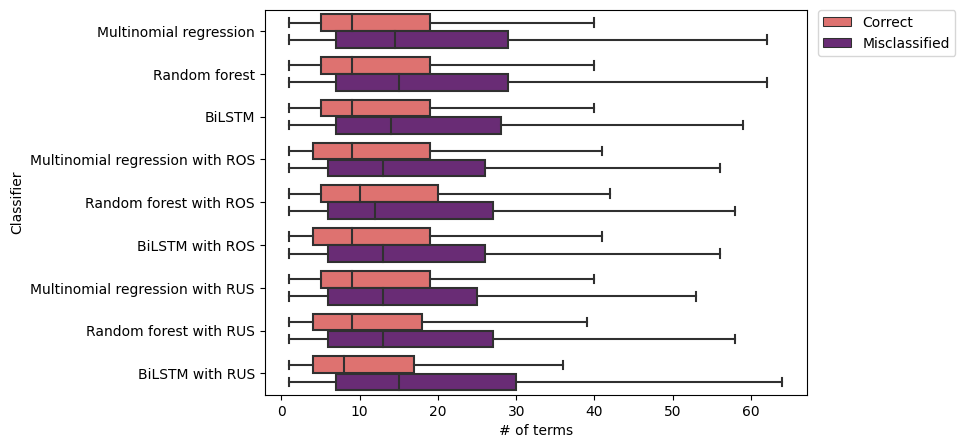

In [72]:
#plt.rcParams['figure.figsize'] = [7, 5]

plt.figure(figsize=(7, 5))

logreg_correct = [len(x.split()) for x in X_test.iloc[np.where(y_pred_logreg == y_test)]]
logreg_misclassified = [len(x.split()) for x in X_test.iloc[np.where(y_pred_logreg != y_test)]]

rf_correct = [len(x.split()) for x in X_test.iloc[np.where(y_pred_rf == y_test)]]
rf_misclassified = [len(x.split()) for x in X_test.iloc[np.where(y_pred_rf != y_test)]]

bilstm_correct = [len(x.split()) for x in X_test.iloc[np.where(np.argmax(y_pred_bilstm, axis = 1) == y_test)]]
bilstm_misclassified = [len(x.split()) for x in X_test.iloc[np.where(np.argmax(y_pred_bilstm, axis = 1) != y_test)]]

logreg_ros_correct = [len(x.split()) for x in X_test.iloc[np.where(y_pred_logreg_ros == y_test)]]
logreg_ros_misclassified = [len(x.split()) for x in X_test.iloc[np.where(y_pred_logreg_ros != y_test)]]

rf_ros_correct = [len(x.split()) for x in X_test.iloc[np.where(y_pred_rf_ros == y_test)]]
rf_ros_misclassified = [len(x.split()) for x in X_test.iloc[np.where(y_pred_rf_ros != y_test)]]

bilstm_ros_correct = [len(x.split()) for x in X_test.iloc[np.where(np.argmax(y_pred_bilstm_ros, axis = 1) == y_test)]]
bilstm_ros_misclassified = [len(x.split()) for x in X_test.iloc[np.where(np.argmax(y_pred_bilstm_ros, axis = 1) != y_test)]]

logreg_rus_correct = [len(x.split()) for x in X_test.iloc[np.where(y_pred_logreg_rus == y_test)]]
logreg_rus_misclassified = [len(x.split()) for x in X_test.iloc[np.where(y_pred_logreg_rus != y_test)]]

rf_rus_correct = [len(x.split()) for x in X_test.iloc[np.where(y_pred_rf_rus == y_test)]]
rf_rus_misclassified = [len(x.split()) for x in X_test.iloc[np.where(y_pred_rf_rus != y_test)]]

bilstm_rus_correct = [len(x.split()) for x in X_test.iloc[np.where(np.argmax(y_pred_bilstm_rus, axis = 1) == y_test)]]
bilstm_rus_misclassified = [len(x.split()) for x in X_test.iloc[np.where(np.argmax(y_pred_bilstm_rus, axis = 1) != y_test)]]

df_boxplot = pd.DataFrame(
    {"# of terms": logreg_correct + logreg_misclassified +
     rf_correct + rf_misclassified +
     bilstm_correct + bilstm_misclassified +
     logreg_ros_correct + logreg_ros_misclassified +
     rf_ros_correct + rf_ros_misclassified +
     bilstm_ros_correct + bilstm_ros_misclassified +
     logreg_rus_correct + logreg_rus_misclassified +
     rf_rus_correct + rf_rus_misclassified +
     bilstm_rus_correct + bilstm_rus_misclassified,
     
     "Classification": ["Correct"] * len(logreg_correct) + ["Misclassified"] * len(logreg_misclassified) +
     ["Correct"] * len(rf_correct) + ["Misclassified"] * len(rf_misclassified) +
     ["Correct"] * len(bilstm_correct) + ["Misclassified"] * len(bilstm_misclassified) +
     ["Correct"] * len(logreg_ros_correct) + ["Misclassified"] * len(logreg_ros_misclassified) +
     ["Correct"] * len(rf_ros_correct) + ["Misclassified"] * len(rf_ros_misclassified) +
     ["Correct"] * len(bilstm_ros_correct) + ["Misclassified"] * len(bilstm_ros_misclassified) +
     ["Correct"] * len(logreg_rus_correct) + ["Misclassified"] * len(logreg_rus_misclassified) +
     ["Correct"] * len(rf_rus_correct) + ["Misclassified"] * len(rf_rus_misclassified) +
     ["Correct"] * len(bilstm_rus_correct) + ["Misclassified"] * len(bilstm_rus_misclassified),
     
     "Classifier": ["Multinomial regression"] * len(y_test) +
     ["Random forest"] * len(y_test) +
     ["BiLSTM"] * len(y_test) +
     ["Multinomial regression with ROS"] * len(y_test) +
     ["Random forest with ROS"] * len(y_test) +
     ["BiLSTM with ROS"] * len(y_test) +
     ["Multinomial regression with RUS"] * len(y_test) +
     ["Random forest with RUS"] * len(y_test) +
     ["BiLSTM with RUS"] * len(y_test)
    })

g = sns.boxplot(data = df_boxplot, x = "# of terms", y = "Classifier", hue = "Classification", palette = "magma_r", showfliers = False)
g.legend(bbox_to_anchor = (1.02, 1), loc = "upper left", borderaxespad = 0)

#### Length of preprocessed reviews

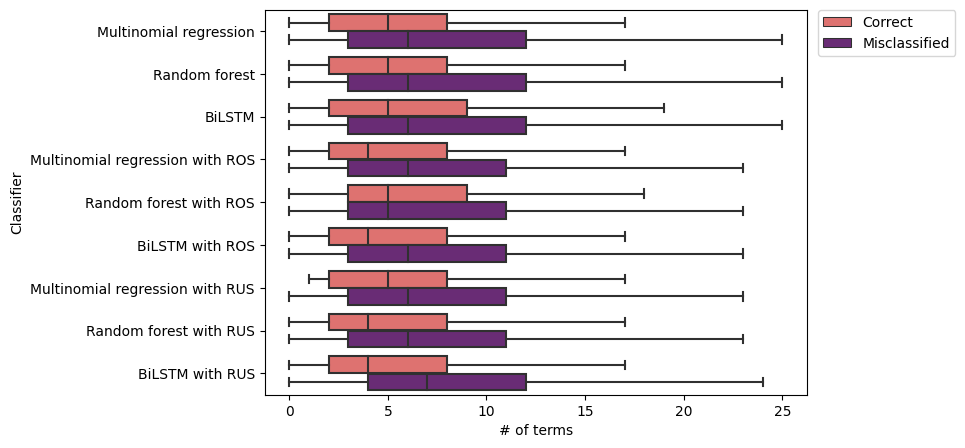

In [73]:
X_test_preprocessed = [preprocess(x) for x in X_test]
X_test_preprocessed_len = [len(x) for x in X_test_preprocessed]

logreg_correct_preprocessed = np.array(X_test_preprocessed_len)[np.where(y_pred_logreg == y_test)].tolist()
logreg_misclassified_preprocessed = np.array(X_test_preprocessed_len)[np.where(y_pred_logreg != y_test)].tolist()

rf_correct_preprocessed = np.array(X_test_preprocessed_len)[np.where(y_pred_rf == y_test)].tolist()
rf_misclassified_preprocessed = np.array(X_test_preprocessed_len)[np.where(y_pred_rf != y_test)].tolist()

bilstm_correct_preprocessed = np.array(X_test_preprocessed_len)[np.where(np.argmax(y_pred_bilstm, axis = 1) == y_test)].tolist()
bilstm_misclassified_preprocessed = np.array(X_test_preprocessed_len)[np.where(np.argmax(y_pred_bilstm, axis = 1) != y_test)].tolist()

logreg_ros_correct_preprocessed = np.array(X_test_preprocessed_len)[np.where(y_pred_logreg_ros == y_test)].tolist()
logreg_ros_misclassified_preprocessed = np.array(X_test_preprocessed_len)[np.where(y_pred_logreg_ros != y_test)].tolist()

rf_ros_correct_preprocessed = np.array(X_test_preprocessed_len)[np.where(y_pred_rf_ros == y_test)].tolist()
rf_ros_misclassified_preprocessed = np.array(X_test_preprocessed_len)[np.where(y_pred_rf_ros != y_test)].tolist()

bilstm_ros_correct_preprocessed = np.array(X_test_preprocessed_len)[np.where(np.argmax(y_pred_bilstm_ros, axis = 1) == y_test)].tolist()
bilstm_ros_misclassified_preprocessed = np.array(X_test_preprocessed_len)[np.where(np.argmax(y_pred_bilstm_ros, axis = 1) != y_test)].tolist()

logreg_rus_correct_preprocessed = np.array(X_test_preprocessed_len)[np.where(y_pred_logreg_rus == y_test)].tolist()
logreg_rus_misclassified_preprocessed = np.array(X_test_preprocessed_len)[np.where(y_pred_logreg_rus != y_test)].tolist()

rf_rus_correct_preprocessed = np.array(X_test_preprocessed_len)[np.where(y_pred_rf_rus == y_test)].tolist()
rf_rus_misclassified_preprocessed = np.array(X_test_preprocessed_len)[np.where(y_pred_rf_rus != y_test)].tolist()

bilstm_rus_correct_preprocessed = np.array(X_test_preprocessed_len)[np.where(np.argmax(y_pred_bilstm_rus, axis = 1) == y_test)].tolist()
bilstm_rus_misclassified_preprocessed = np.array(X_test_preprocessed_len)[np.where(np.argmax(y_pred_bilstm_rus, axis = 1) != y_test)].tolist()

df_boxplot_preprocessed = pd.DataFrame(
    {"# of terms": logreg_correct_preprocessed + logreg_misclassified_preprocessed +
     rf_correct_preprocessed + rf_misclassified_preprocessed +
     bilstm_correct_preprocessed + bilstm_misclassified_preprocessed +
     logreg_ros_correct_preprocessed + logreg_ros_misclassified_preprocessed +
     rf_ros_correct_preprocessed + rf_ros_misclassified_preprocessed +
     bilstm_ros_correct_preprocessed + bilstm_ros_misclassified_preprocessed +
     logreg_rus_correct_preprocessed + logreg_rus_misclassified_preprocessed +
     rf_rus_correct_preprocessed + rf_rus_misclassified_preprocessed +
     bilstm_rus_correct_preprocessed + bilstm_rus_misclassified_preprocessed,
     
     "Classification": ["Correct"] * len(logreg_correct_preprocessed) + ["Misclassified"] * len(logreg_misclassified_preprocessed) +
     ["Correct"] * len(rf_correct_preprocessed) + ["Misclassified"] * len(rf_misclassified_preprocessed) +
     ["Correct"] * len(bilstm_correct_preprocessed) + ["Misclassified"] * len(bilstm_misclassified_preprocessed) +
     ["Correct"] * len(logreg_ros_correct_preprocessed) + ["Misclassified"] * len(logreg_ros_misclassified_preprocessed) +
     ["Correct"] * len(rf_ros_correct_preprocessed) + ["Misclassified"] * len(rf_ros_misclassified_preprocessed) +
     ["Correct"] * len(bilstm_ros_correct_preprocessed) + ["Misclassified"] * len(bilstm_ros_misclassified_preprocessed) +
     ["Correct"] * len(logreg_rus_correct_preprocessed) + ["Misclassified"] * len(logreg_rus_misclassified_preprocessed) +
     ["Correct"] * len(rf_rus_correct_preprocessed) + ["Misclassified"] * len(rf_rus_misclassified_preprocessed) +
     ["Correct"] * len(bilstm_rus_correct_preprocessed) + ["Misclassified"] * len(bilstm_rus_misclassified_preprocessed),
     
     "Classifier": ["Multinomial regression"] * len(y_test) +
     ["Random forest"] * len(y_test) +
     ["BiLSTM"] * len(y_test) +
     ["Multinomial regression with ROS"] * len(y_test) +
     ["Random forest with ROS"] * len(y_test) +
     ["BiLSTM with ROS"] * len(y_test) +
     ["Multinomial regression with RUS"] * len(y_test) +
     ["Random forest with RUS"] * len(y_test) +
     ["BiLSTM with RUS"] * len(y_test)
    })

g = sns.boxplot(data = df_boxplot_preprocessed, x = "# of terms", y = "Classifier", hue = "Classification", palette = "magma_r", showfliers = False)
g.legend(bbox_to_anchor = (1.02, 1), loc = "upper left", borderaxespad = 0)

#### Intersecting misclassifications

In [56]:
np.set_printoptions(suppress = True)

matrix_misclassifications = np.zeros((9,9))

preds = [y_pred_logreg, y_pred_rf, np.argmax(y_pred_bilstm, axis = 1),
 y_pred_logreg_ros, y_pred_rf_ros, np.argmax(y_pred_bilstm_ros, axis = 1),
 y_pred_logreg_rus, y_pred_rf_rus, np.argmax(y_pred_bilstm_rus, axis = 1)]

for i, pred1 in enumerate(preds):
    for j, pred2 in enumerate(preds):
        matrix_misclassifications[i,j] = len(np.intersect1d(np.where(pred1 != y_test), np.where(pred2 != y_test)))

matrix_misclassifications

array([[2720., 2458., 2439., 2088., 2344., 2056., 2026., 2039., 2237.],
       [2458., 2838., 2350., 2053., 2563., 2066., 2016., 2104., 2234.],
       [2439., 2350., 2653., 1980., 2263., 1975., 1931., 1973., 2215.],
       [2088., 2053., 1980., 3865., 2233., 3214., 3209., 2819., 2398.],
       [2344., 2563., 2263., 2233., 3149., 2270., 2230., 2424., 2195.],
       [2056., 2066., 1975., 3214., 2270., 4061., 3123., 2826., 2491.],
       [2026., 2016., 1931., 3209., 2230., 3123., 4217., 3150., 2529.],
       [2039., 2104., 1973., 2819., 2424., 2826., 3150., 4384., 2531.],
       [2237., 2234., 2215., 2398., 2195., 2491., 2529., 2531., 3483.]])